# IMPORT

In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython.display import display, Image
import matplotlib.image as mpimg
import pathlib
from pathlib import Path
import zipfile
from zipfile import ZipFile
import glob 
import os
import shutil
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import preprocess_input

# Organize Data

In [41]:
data_dir = pathlib.Path(r"D:\CoderSchool_ML30\Week 9\Data\Train Dataset")

In [42]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset= "training",
  labels = 'inferred',
  label_mode = 'categorical',
  seed=42,
  image_size=(224, 224),
  batch_size=32)

Found 300 files belonging to 3 classes.
Using 240 files for training.


In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  labels = 'inferred',
  label_mode = 'categorical',
  seed=42,
  image_size=(224, 224),
  batch_size=32)

Found 300 files belonging to 3 classes.
Using 60 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['Nguyen', 'Tam', 'Thu']


# Pipeline for Classification

## Define functions

### Preprocessing layers

In [23]:
# Resize & Scale layers
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [66]:
# Augmentation layers
np.random.seed(42)

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

Let's visualize a random image before augmentation

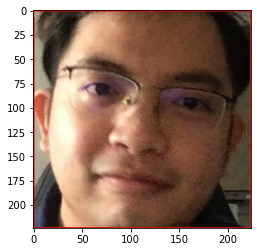

In [67]:
images, labels = next(iter(train_ds.take(1)))
image = images[1].numpy().astype("uint8")
plt.imshow(image)
plt.show()

In [68]:
# Add the image to a batch & plot
image = tf.expand_dims(image, 0)

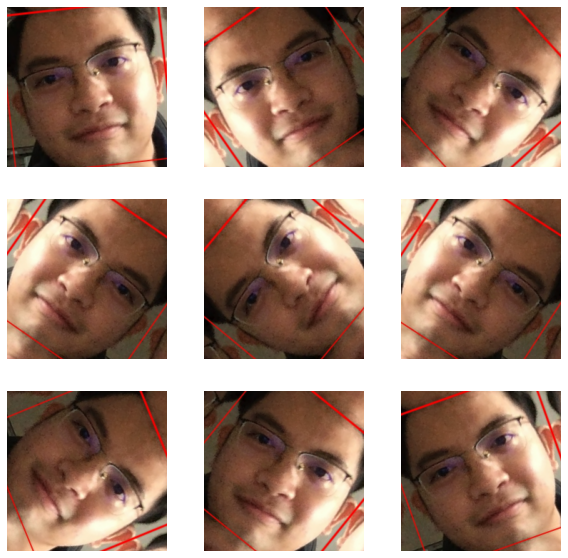

In [69]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

### Checkpoints

In [28]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="my_model_checkpoint.h5",
                                                 save_weights_only=False, # the whole model (False) or only weights (True) 
                                                 save_best_only=True, # keep the best model with lowest validation loss
                                                 monitor='val_loss',
                                                 verbose=1)

## Transfer Learning

In [29]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

base_model = tf.keras.applications.xception.Xception(weights='imagenet',
                                            input_shape=(224, 224, 3),
                                            include_top=False)

# Freeze the base model's weights 
base_model.trainable = False 

base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [30]:
def make_xception():
  inputs = tf.keras.Input(shape=(224,224,3))
  x = layers.experimental.preprocessing.Resizing(224,224)(inputs)
  x = tf.keras.applications.xception.preprocess_input(x)
  x = data_augmentation(x)
  x = base_model(x, training=False)
  x = layers.GlobalAveragePooling2D()(x) 
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(3, activation='softmax')(x)
  model = tf.keras.Model(inputs, outputs)
  return model

model = make_xception()
opt = Adam()
model.compile(optimizer= opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
init_epochs = 5

history = model.fit(train_ds,              
                    validation_data=val_ds, 
                    callbacks=[checkpoint_callback, earlystopping_callback],
                    epochs=init_epochs)

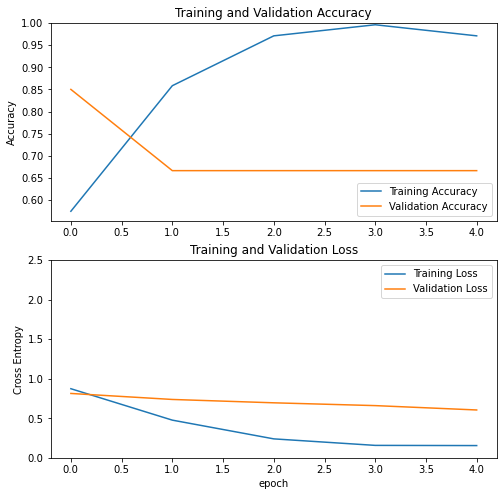

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tuning

In [ ]:
# Unfreeze the base_model.
base_model.trainable = True

# Fine-tune from 
fine_tune_at = 109

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
init_epochs = 5
fine_tune_epochs = 20
total_epochs = init_epochs + fine_tune_epochs

history_fine = model.fit(train_ds, 
                         validation_data= val_ds,
                         epochs=total_epochs,
                         initial_epoch=init_epochs,
                         callbacks=[checkpoint_callback, earlystopping_callback])

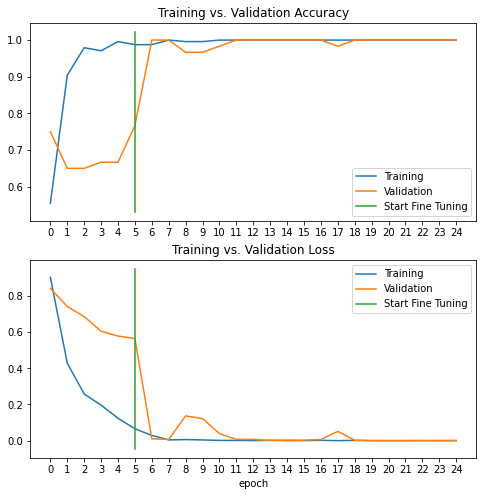

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0.9, 1])
plt.plot([init_epochs,init_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training vs. Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.xticks(range(total_epochs))
# plt.ylim([0, 0.5])
plt.plot([init_epochs,init_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training vs. Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, acc = model.evaluate(val_ds)
print("Validation Loss: {:.2f}".format(loss))
print("Validation Accuracy: {:.2f}%".format(100*acc))

2/2 [==============================] - 0s 79ms/step - loss: 0.0011 - accuracy: 1.0000
Validation Loss: 0.00
Validation Accuracy: 100.00%


In [ ]:
loss, acc = model.evaluate(train_ds)
print("Train Loss: {:.2f}".format(loss))
print("Train Accuracy: {:.2f}%".format(100*acc))

8/8 [==============================] - 1s 77ms/step - loss: 1.5254e-04 - accuracy: 1.0000
Train Loss: 0.00
Train Accuracy: 100.00%


### Save & Load model

In [ ]:
model.save("/content/gdrive/MyDrive/Colab Notebooks/Week 9 - OpenCV/Project/Model_Save/xception.h5") 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [44]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(r"D:\CoderSchool_ML30\Week 9\Model_save\xception.h5")

# We need to define its optimizer and loss function again since the h5 file
# does not contain those information :(
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# # Re-evaluate the model
# loss, acc = model.evaluate(val_ds)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))

### Test

In [33]:
from tensorflow.keras.preprocessing import image

def plot_test_image(img_path, model):
    # display part
    IMG_SIZE = 224
    img        = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array  = image.img_to_array(img)
    img_array  = np.expand_dims(img_array, axis=0)
    # prediction part
    img_array = get_img_array(img_path, IMG_SIZE)
    prediction = model.predict(img_array)
    pred_indices = prediction[0].argmax()
    labels=train_ds.class_names

    plt.figure(figsize=(5,5))
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f'Prediction: {labels[pred_indices]} with {round(prediction.max()*100,2)}%')
    plt.axis('off')
    plt.grid(b=None)
    plt.show()

In [ ]:
# plotting functions
def get_img_array(img_path, img_size):
    # `img` is a PIL image
    img = keras.preprocessing.image.load_img(img_path, target_size=(img_size,img_size)) # load and resize
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    # array = preprocess_input(array)     # comment this line if model includes a preprocessing layer
    return array

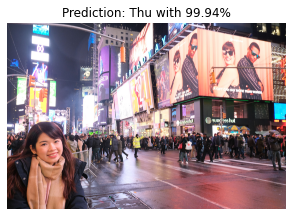

In [ ]:
plot_test_image(img_path, model)

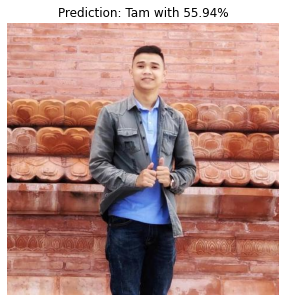

In [ ]:
img_path = r"D:\CoderSchool_ML30\Week 9\Data\Test set\tam-test.jpg"

plot_test_image(img_path, model)

# Yolo for Face Detection

In [45]:
# Load model
import cv2
model_path = 'D:\CoderSchool_ML30\Week 9\yolo\yolov3-face.cfg'
weight_path = 'D:\CoderSchool_ML30\Week 9\yolo\yolov3-wider_16000.weights'

net = cv2.dnn.readNetFromDarknet(model_path, weight_path)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [46]:
# get detection from Yolo
def blob_image():
    IMG_WIDTH, IMG_HEIGHT = 416, 416
    
    # Making blob object from original image
    blob = cv2.dnn.blobFromImage(frame, 1/255, (IMG_WIDTH, IMG_HEIGHT), (0, 0, 0), 1, crop=False)

    # Set model input
    net.setInput(blob)
    # Define the layers that we want to get the outputs from
    output_layers = net.getUnconnectedOutLayersNames()
    # Run 'prediction'
    outs = net.forward(output_layers)
    return outs

In [47]:
# Get the bounding box
def bbox():
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]

    # Scan through all the bounding boxes output from the network and keep only
    # the ones with high confidence scores. Assign the box's class label as the
    # class with the highest score.

    confidences = []
    boxes = []
    # class_ids = []

    # Each frame produces 3 outs corresponding to 3 output layers
    for out in outs:
	# One out has multiple predictions for multiple captured objects.
        for detection in out:
            confidence = detection[-1]
		    # Extract position data of face area (only area with high confidence)
            if confidence > 0.8:
                center_x = int(detection[0] * frame_width)
                center_y = int(detection[1] * frame_height)
                width = int(detection[2] * frame_width)
                height = int(detection[3] * frame_height)
            
			    # Find the top left point of the bounding box 
                topleft_x = int(center_x - 1/2*width)
                topleft_y = int(center_y - 1/2*height)
                confidences.append(float(confidence))
                boxes.append([topleft_x, topleft_y, width, height])

    # Perform non-maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    return confidences, boxes, indices

In [53]:
# Display information on bounding box
def face_clf():
    final_boxes = []
    for i in indices:
        i = i[0]
        box = boxes[i]
        final_boxes.append(box)

        # Extract position data
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]

        crop = frame[top:top+height, left:left+width]
        crop = cv2.resize(crop, (224,224), interpolation=cv2.INTER_AREA)

        crop = preprocess_input(crop)
        #make predicton:
        prediction = model.predict(np.array([crop]))
        pred_ind = np.argmax(prediction, axis=-1)
        label = class_names[pred_ind[0]]

        # Draw bounding box with the above measurements
        cv2.rectangle(frame, (left, top), (left+width, top+height), (0,255,0), 1)
		# Display text about confidence rate above each box
        text = f'{confidences[i]:.2f}'
        cv2.putText(frame, label + ' ' + text, (left, top + 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2, cv2.LINE_AA)
        cv2.putText(frame, f'Number of faces detected {len(boxes)}', (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 1, cv2.LINE_AA)
    return frame

# Real-time face recognition

In [ ]:
# Real-time Face Identification
import cv2
cam = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    rec, frame = cam.read()
    
    outs = blob_image()
    confidences, boxes, indices = bbox()
    face_clf()
    cv2.imshow('Frame',frame)
    
    c= cv2.waitKey(1) & 0xFF 
    if c == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()
    